In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette("Blues")

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.cluster import KMeans

pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

In [2]:
INPUT_FOLDER = Path('../../data/interim/')
train_file = Path('train_prepared.csv')
test_file = Path('test_prepared.csv')

seed = 1337

In [3]:
train = pd.read_csv(INPUT_FOLDER/train_file, index_col=0)
test = pd.read_csv(INPUT_FOLDER/test_file, index_col=0)

In [4]:
train.tail()

,Elevation,Horizontal_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Horizontal_Distance_To_Fire_Points,Stoneyness,Wilderness,SoilType,Euclidean_distance_to_hydro,distance_hydro_fire,distance_road_hydro,distance_sum_hydro_fire,distance_sum_road_hydro,distance_dif_road_fire,distance_dif_hydro_road,distance_dif_hydro_fire,shade_3pm_diff,ElevationHydro,ElevationV,ElevationH,Elevation2,ElevationLog,Aspect_cos,Cover_Type
15116,2603,633,618,249,221,1325,1,2,17,662.354890,993.677445,640.177445,1987.354890,1280.354890,-707,44.354890,-662.645110,130,2437.411278,2408,2482.73,6775609,7.864804,-0.515038,3
15117,2492,365,335,250,220,1187,1,2,17,383.293621,785.146811,359.146811,1570.293621,718.293621,-852,48.293621,-803.706379,137,2396.176595,2375,2422.65,6210064,7.821242,-0.694658,3
15118,2487,218,242,229,237,932,1,2,17,240.260276,586.130138,241.130138,1172.260276,482.260276,-690,-1.739724,-691.739724,118,2426.934931,2386,2445.58,6185169,7.819234,-0.974370,3
15119,2475,319,270,189,244,914,3,2,5,328.397625,621.198812,299.198812,1242.397625,598.397625,-644,58.397625,-585.602375,80,2392.900594,2397,2414.39,6125625,7.814400,-0.956305,3
15120,2680,0,2684,196,214,6645,4,0,10,0.000000,3322.500000,1342.000000,6645.000000,2684.000000,-3961,-2684.000000,-6645.000000,58,2680.000000,2680,2680.00,7182400,7.893945,0.994522,1


### Preparing the data

In [5]:
kfold = KFold(n_splits=5)

X = train.drop('Cover_Type', 1)
y = train['Cover_Type']

X_val = test.drop('Cover_Type', 1)
y_val = test['Cover_Type']

### Baseline model training

In [6]:
rf_baseline_model = RandomForestClassifier(n_estimators=400, random_state=seed, n_jobs=-1)
oof_predictions = cross_val_predict(rf_baseline_model, X, y, cv=kfold)
rf_baseline_model = rf_baseline_model.fit(X, y)

In [7]:
importance = pd.DataFrame({'feature': X.columns, 'importance': rf_baseline_model.feature_importances_}).sort_values(
    by='importance', ascending=False)

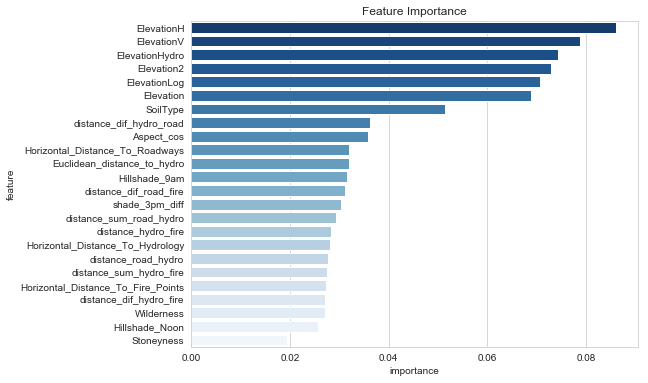


> Random Forest baseline model accuracy score: 0.8314

              precision    recall  f1-score   support

           1       0.72      0.74      0.73      2161
           2       0.73      0.63      0.68      2160
           3       0.80      0.80      0.80      2160
           4       0.93      0.96      0.95      2160
           5       0.87      0.93      0.90      2160
           6       0.82      0.82      0.82      2160
           7       0.91      0.94      0.93      2160

    accuracy                           0.83     15121
   macro avg       0.83      0.83      0.83     15121
weighted avg       0.83      0.83      0.83     15121



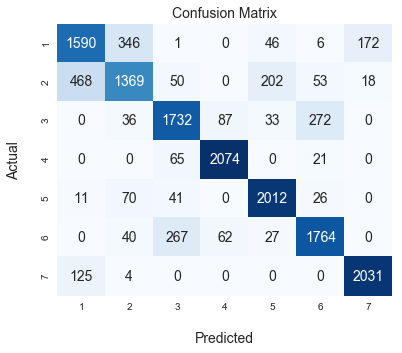

In [8]:
plt.figure(figsize=(8, 6))
sns.barplot(x=importance['importance'], y=importance['feature'], palette='Blues_r')
plt.title('Feature Importance')
plt.show()

print(f'\n> Random Forest baseline model accuracy score: {round(accuracy_score(y, oof_predictions), 4)}\n')

print(classification_report(y, oof_predictions))

cm = confusion_matrix(y, oof_predictions)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', annot_kws={'fontsize': 14}, cmap='Blues', cbar=False)
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('\nPredicted', fontsize=14)
plt.ylabel('Actual\n', fontsize=14)
plt.yticks(ticks=np.arange(0.5, 7.5), labels=list(range(1, 8)), fontsize=10)
plt.xticks(ticks=np.arange(0.5, 7.5), labels=list(range(1, 8)), fontsize=10)
plt.show()

We can see the model is doing ok, but it's having a hard time distinguishing between a few classes, particularly class 2, where it had an F1-Score of only 68%.

- First Solution

Find models that perfom better.

- Second Solution

Find features that help to distinguish specific classes, specially the ones that the models is having a hard time classifing.

### Validation Results

In [9]:
predictions = rf_baseline_model.predict(X_val)

In [10]:
accuracy_score(y_val, predictions)

0.7710619182846167